# Demo of STARCOP models on EMIT data

Demos with loading AVIRIS trained models and their zero-shot generalisation on the data from EMIT.

In [ ]:
!pip install --quiet rasterio
!pip install --quiet --upgrade gdown

In [ ]:
# Clone the repository:
!git clone https://github.com/spaceml-org/STARCOP.git

In [2]:
# Data:
# STARCOP_EMIT_eval.zip with 341 MB
!gdown https://drive.google.com/uc?id=1gFc5r2kkzZut_2H0vheupI9enWerFf2x -O STARCOP_EMIT_eval.zip

# Models:
!gdown https://drive.google.com/uc?id=1Kvnc_lOBn4z-xO1HFRyLZOMEldXWQvql -O hyperstarcop_magic_rgb.zip

Downloading...
From (uriginal): https://drive.google.com/uc?id=1gFc5r2kkzZut_2H0vheupI9enWerFf2x
From (redirected): https://drive.google.com/uc?id=1gFc5r2kkzZut_2H0vheupI9enWerFf2x&confirm=t&uuid=6ccd4180-0c1c-4cc6-9765-08b8822a77e7
To: /content/STARCOP_EMIT_eval.zip
100% 358M/358M [00:02<00:00, 172MB/s]
Downloading...
From (uriginal): https://drive.google.com/uc?id=1Kvnc_lOBn4z-xO1HFRyLZOMEldXWQvql
From (redirected): https://drive.google.com/uc?id=1Kvnc_lOBn4z-xO1HFRyLZOMEldXWQvql&confirm=t&uuid=3cc31307-039a-44e5-84cd-147d3589fc0c
To: /content/hyperstarcop_magic_rgb.zip
100% 73.3M/73.3M [00:00<00:00, 136MB/s]


In [4]:
!unzip -q STARCOP_EMIT_eval.zip
!unzip -q hyperstarcop_magic_rgb.zip
# clean-up
!rm *.zip

In [5]:
!ls

EMIT_DATASET_v1_NONORTHO  hyperstarcop_magic_rgb  sample_data  STARCOP


In [6]:
%cd /content/STARCOP

/content/STARCOP


In [ ]:
!pip --quiet install -r requirements.txt
# ignore the warnings about the library versions

In [ ]:
# additional libraries and exact versions:
!pip install git+https://github.com/spaceml-org/georeader.git
!pip install torchtext==0.14.1

In [ ]:
assert False
# please restart the runtime with the button above ^

In [1]:
%cd /content/STARCOP

/content/STARCOP


In [2]:
import omegaconf
import pylab as plt
import torch
import omegaconf
import fsspec
import os
import json
import pandas as pd
import numpy as np
from starcop.torch_utils import to_device
import starcop.plot as starcoplot
from mpl_toolkits.axes_grid1 import make_axes_locatable

from starcop.data.datamodule import Permian2019DataModule
from starcop.emit_tools.emit_as_datamodule import EMITDataModule
from starcop.models.model_module import ModelModule
from starcop.validation import run_validation

device = torch.device("cuda:0")
fs = fsspec.filesystem("gs")
config_general = omegaconf.OmegaConf.load("scripts/configs/config.yaml")
root_folder = "/content/EMIT_DATASET_v1_NONORTHO"
labels_filename = "label_nonortho.tif"

## HyperSTARCOP

In [3]:
hsi_model_path = "/content/hyperstarcop_magic_rgb/final_checkpoint_model.ckpt"
hsi_config_path = "/content/hyperstarcop_magic_rgb/config.yaml"

In [4]:
def load_model_with_emit(model_path, config_path):
    config_model = omegaconf.OmegaConf.load(config_path)
    config = omegaconf.OmegaConf.merge(config_general, config_model)

    # note, the EMIT data module works differently than the one prepared for AVIRIS data - it's also meant only for evaluation
    data_module = EMITDataModule(config, labels_filename, root_folder=root_folder)
    data_module.prepare_data()

    model = ModelModule.load_from_checkpoint(model_path, settings=config)
    model.to(device)
    model.eval() # !

    print("Loaded model with",model.num_channels,"input channels, data module with", len(data_module.input_products), "input bands")

    return model, data_module, config

hsi_model, hsi_dm, hsi_config = load_model_with_emit(hsi_model_path, hsi_config_path)
print("successfully loaded HyperSTARCOP model!")

Made the EMITDataModule with these self.input_products ['mag1c', 'TOA_AVIRIS_640nm', 'TOA_AVIRIS_550nm', 'TOA_AVIRIS_460nm'] will load these: all


/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Loaded 20 samples. First one (rgb, magic, label): (3, 1280, 1242) (1280, 1242) (1280, 1242) paths like /content/EMIT_DATASET_v1_NONORTHO/plume_events/EMIT_L1B_RAD_001_20220815T042838_2222703_003/EMIT_L1B_RAD_001_20220815T042838_2222703_003_radiance_RGB
Loaded model with 4 input channels, data module with 4 input bands
successfully loaded HyperSTARCOP model!


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


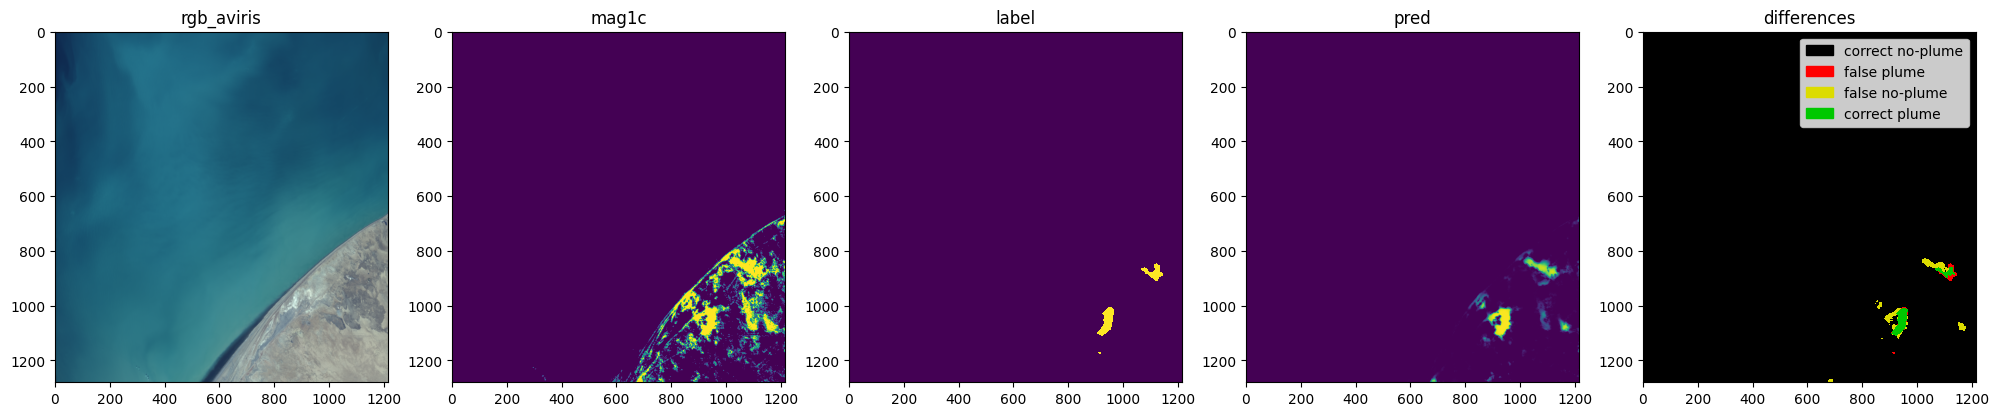

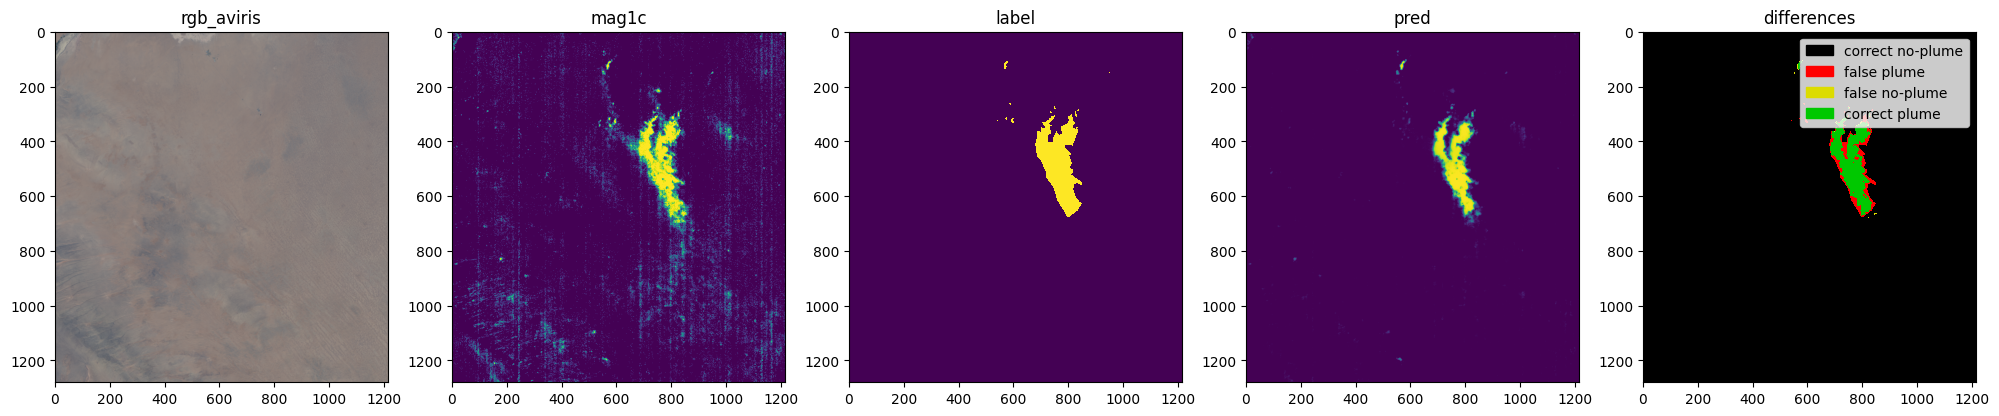

In [5]:
dataloader = hsi_dm.test_dataloader(batch_size=1)
nice_ones = [2, 4]
for i, plume_data in enumerate(dataloader):
    if not i in nice_ones:
      continue
    plume_data = hsi_model.batch_with_preds(to_device(plume_data, hsi_model.device))
    fig = starcoplot.plot_batch(to_device(plume_data,"cpu"), input_products=hsi_config.dataset.input_products,
                                products_plot=hsi_config.products_plot, figsize_ax=(4, 4))

    plt.show(fig)
    plt.close()

    if i > max(nice_ones):
        break

In [ ]:
# from starcop.validation import run_validation
# # Note: the test dataset is just a subset in this demo
# dataloader = hsi_dm.test_dataloader(batch_size=1)
# hsi_metrics_per_id, hsi_metrics = run_validation(hsi_model, dataloader, products_plot=hsi_config.products_plot, verbose=True,
#                                           show_plots=True, skip_saving_plots=True, # < for showing
#                                           #show_plots=False, skip_saving_plots=False, # < for saving
#                                           path_save_results="hyperstarcop_emit_outputs")